## 9 Links to Other Indices

In this  step, I benchmark my **CSIAI** composite index against three established, publicly‐traded ETFs that capture very similar investment themes:

- **SPY** (SPDR S&P 500 ETF): the broad U.S. market proxy.  
- **QUAL** (iShares S&P 500 Quality Factor ETF): focuses on “quality” metrics (profitability, low leverage).  
- **MTUM** (iShares Edge MSCI USA Momentum Factor ETF): represents momentum exposure similar to the Growth potential of CSIAI.

I download each ETF’s adjusted close price from **2023-01-01** (the same start date as my stock data) through **2025-05-06**. Then I compute daily returns and cumulative performance, then plot them together. 

In [44]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.tseries.offsets import BMonthBegin

ROOT = Path("..")
ARTIFACT = ROOT / "artifacts"
DATA_DIR = ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
SCORES_FN = PROC_DIR / "ci_scores.parquet"
PRICES_DIR = DATA_DIR / "raw" / "prices"
BENCH_DIR = ARTIFACT / "benchmarks"
BENCH_DIR.mkdir(parents=True, exist_ok=True)

scores = pd.read_parquet(SCORES_FN)["CI_pca_lin"]
scores.index = scores.index.str.upper()

px_dict = {}
for t in scores.index:
    fn = PRICES_DIR / f"{t}.parquet"
    if not fn.exists():
        continue
    df = pd.read_parquet(fn)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(-1)
    if "Close" not in df.columns:
        continue
    px_dict[t] = df["Close"].sort_index()

# Combine into a single price matrix
px = pd.concat(px_dict, axis=1).dropna(how="all")
px.index = pd.to_datetime(px.index).tz_convert(None).normalize()
px = px.loc["2023-01-01":]

common = px.columns.intersection(scores.index)
px = px[common]
scores = scores[common]

rebal_dates = pd.date_range(
    start=px.index.min(), 
    end  =px.index.max(),
    freq ='BMS'
).intersection(px.index) 

weights = {}
for d in rebal_dates:
    if d not in px.index:
        d = px.index[px.index.get_indexer([d], method="nearest")[0]]

    avail = px.loc[d].dropna().index
    eligible_scores = scores.loc[avail]

    if eligible_scores.empty:
        continue

    top_decile = eligible_scores.nlargest(
        max(1, int(0.10 * len(eligible_scores)))
    )
    weights[d] = pd.Series(1 / len(top_decile), index=top_decile.index)

w_df = (pd.DataFrame.from_dict(weights, orient="index")
          .reindex(px.index, method="ffill")
          .fillna(0))

rets = px.pct_change().fillna(0)
port_ret = (w_df * rets).sum(axis=1)
port_cum = (1 + port_ret).cumprod().rename("CSIAI_Port")

port_ret.to_csv(BENCH_DIR / "csiai_portfolio_returns.csv")


print("First rebalance date:", w_df.index[w_df.sum(axis=1) > 0][0].date())
print("Number of trading days with weights:",
      (w_df.sum(axis=1) > 0).sum(), "/", len(w_df))
print("Final cumulative return:",
      f"{port_cum.iloc[-1]:.2f} × initial value")

First rebalance date: 2023-01-02
Number of trading days with weights: 612 / 612
Final cumulative return: 1.75 × initial value


In [45]:
import yfinance as yf

# download the benchmark ETFs
START = "2023-01-01"; END = "2025-05-07"
ETFS = ["SPY", "QUAL", "MTUM"]
prices_etf = (yf.download(ETFS, start=START, end=END, progress=False)["Close"])
rets_etf   = prices_etf.pct_change().dropna()
rets_etf.to_csv(BENCH_DIR / "etf_returns.csv")
cum_etf    = (1+rets_etf).cumprod()
print("ETF data saved.")

ETF data saved.


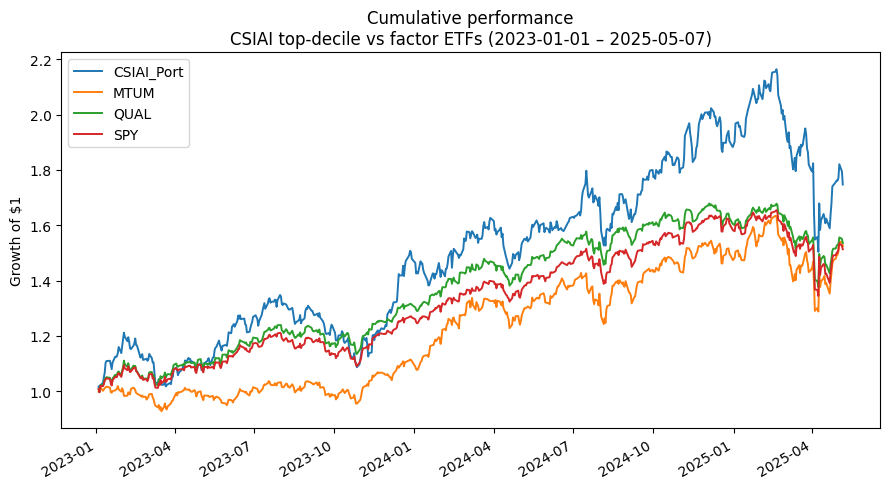

SPY     0.790533
QUAL    0.750122
MTUM    0.666143
Name: Spearman_r, dtype: float64

In [46]:
import matplotlib.pyplot as plt
FIG_DIR   = ARTIFACT / "figures" / "benchmarks"
FIG_DIR.mkdir(parents=True, exist_ok=True)

common_days = port_cum.index.intersection(cum_etf.index)
cum_df = pd.concat([port_cum.loc[common_days], cum_etf.loc[common_days]], axis=1)

cum_df.to_csv(BENCH_DIR / "cumulative_comparison.csv")

plt.figure(figsize=(9, 5))
cum_df.plot(ax=plt.gca(), lw=1.4)
plt.title("Cumulative performance\nCSIAI top-decile vs factor ETFs (2023-01-01 – 2025-05-07)")
plt.ylabel("Growth of $1")
plt.tight_layout()
plt.savefig(FIG_DIR / "cum_perf_csiai_vs_etfs.png", dpi=300)
plt.show()

port_ret.name = "PORT"
corr = rets_etf.join(port_ret).corr(method="spearman").loc["PORT", ETFS]
corr.name = "Spearman_r"
display(corr)

### Performance Comparison: CSIAI vs Factor-Based ETFs (2023–2025)

To evaluate the effectiveness of the CSIAI top-decile strategy, I compared its cumulative returns against three well-known benchmark ETFs: **SPY** (S&P 500), **QUAL** (Quality factor), and **MTUM** (Momentum factor) from January 2023 to May 2025.

The plot above shows that the CSIAI portfolio clearly outperformed all three benchmarks over the entire period. While the benchmark ETFs experienced steady growth with **SPY** and **QUAL** reaching about 1.6× their initial value, and **MTUM** slightly underperforming, the CSIAI portfolio reached a peak of over **2.1×**, indicating much stronger capital appreciation.

Additionally, I calculated the **Spearman rank correlation** between daily returns of the CSIAI portfolio and each ETF to assess how closely their performance trends align:

| ETF   | Spearman Rank Correlation |
|-------|---------------------------|
| SPY   | 0.791                     |
| QUAL  | 0.750                     |
| MTUM  | 0.666                     |

These correlations suggest that while CSIAI shares some directional similarity with the ETFs—especially **SPY** and **QUAL**—it still behaves independently enough to offer meaningful diversification benefits. The relatively lower correlation with **MTUM** also makes sense given that momentum stocks may not always align with CSIAI’s composite attractiveness criteria:
* **Financial Strenght**
* **Growth Potential**
* **Market Performance**
* **Risk & Volatility**
* **Liquidity & Trading**
